In [0]:
import os
!pip install pyspark
!pip install surprise
import surprise
from surprise import KNNWithMeans
from sklearn.neighbors import NearestNeighbors
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD
from scipy.sparse import csr_matrix
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
# NEW IMPORT
!pip install pyspark_dist_explore
import pyspark_dist_explore
from pyspark_dist_explore import hist
from pyspark.sql.functions import col
# End of New Import
!pip install mxnet
import matplotlib.pyplot as plt
import mxnet
from mxnet import gluon
!pip install d2l
import d2l
from d2l import mxnet as d2l
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q  https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from sklearn.linear_model import LinearRegression

     |▍

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 46.9 MB 312 kB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 120 kB 6.3 MB/s 
     |████████████████████████████████| 58 kB 8.6 MB/s 
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
debconf: delaying package configuration, since apt-utils is not installed
tar: spark-3.2.0-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Collaborative Filtering with PySpark-Netflix")\
        .config("spark.scheduler.mode", "FAIR")\
        .config("spark.speculation", "false")\
        .config('spark.ui.port', '4050')\
        .enableHiveSupport()\
        .getOrCreate()
sc = spark.sparkContext
spark1 = SQLContext(sc)


/databricks/spark/python/pyspark/sql/context.py:82: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
sc.setCheckpointDir('/FileStore/shared_uploads/jacksmith156403@gmail.com/')

In [0]:
url = 'https://media.githubusercontent.com/media/JackSmith156403/parallel/main/smaller_netflix.csv'
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
# df = spark.read.csv(SparkFiles.get("smaller_netflix.csv"), header=True)
ratings = spark.read.csv("file://"+SparkFiles.get("smaller_netflix.csv"), header=True, inferSchema= True)

In [0]:
ratings.columns

Out[5]: ['_c0', 'user_id', 'ratings', 'movie_id', 'Year', 'Name']

In [0]:
columns_to_drop = ['_c0', 'Year','Name']
ratings = ratings.drop(*columns_to_drop)

In [0]:
print(ratings.head())

Row(user_id=1734805, ratings=1.0, movie_id=1502)


In [0]:
#This will give a bird’s-eye view of the columns in the dataframe along with their data types.
print(ratings.columns)

['user_id', 'ratings', 'movie_id']


In [0]:
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- ratings: double (nullable = true)
 |-- movie_id: integer (nullable = true)



In [0]:
for line in ratings.head(5):
  print(line, '\n')


Row(user_id=1734805, ratings=1.0, movie_id=1502) 

Row(user_id=889439, ratings=3.0, movie_id=1502) 

Row(user_id=2480084, ratings=3.0, movie_id=1502) 

Row(user_id=276813, ratings=1.0, movie_id=1502) 

Row(user_id=1794216, ratings=4.0, movie_id=1502) 



In [0]:
ratings.describe().show()

+-------+------------------+------------------+-----------------+
|summary|           user_id|           ratings|         movie_id|
+-------+------------------+------------------+-----------------+
|  count|           6198103|           6198103|          6198103|
|   mean|1320692.0918810158| 3.581135066648618|2491.494400625482|
| stddev| 764509.6153387855|1.0590402682441933|590.4719360110003|
|    min|                 6|               1.0|             1502|
|    max|           2649336|               5.0|             3500|
+-------+------------------+------------------+-----------------+



In [0]:
from pyspark.sql.functions import format_number
summary = ratings.describe()
summary.select(summary['summary'],
               format_number(summary['ratings'].cast('float'),2).alias('ratings'),
              #  format_number(summary['Year'].cast('int'),0).alias('year')
               ).show()

+-------+------------+
|summary|     ratings|
+-------+------------+
|  count|6,198,103.00|
|   mean|        3.58|
| stddev|        1.06|
|    min|        1.00|
|    max|        5.00|
+-------+------------+



In [0]:
print("Number of rows in Dataframe: ",ratings.count())
user_count=ratings.select('user_id').distinct().count()
print("Total Number of users: " ,user_count)
movie_count=ratings.select('movie_id').distinct().count()
print("Total Number of movies: " ,movie_count)
ratings_count=ratings.select('ratings').count()
print("Total Number of ratings: ",ratings_count)

Number of rows in Dataframe:  6198103
Total Number of users:  95325
Total Number of movies:  412
Total Number of ratings:  6198103


In [0]:
sparsity= ratings_count/(user_count*movie_count)
print("Matrix sparsity for Netflix-6.7M: ",sparsity)

Matrix sparsity for Netflix-6.7M:  0.1578173545280708


Out[15]: Text(0.5, 1.0, 'Distribution of Ratings in Netflix Dataset')

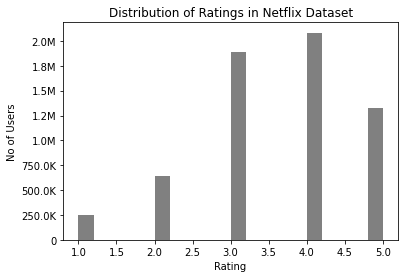

In [0]:
fig, ax = plt.subplots()
hist(ax, ratings.select(col('ratings')), bins = 20, color=['grey'])
plt.xlabel('Rating')
plt.ylabel('No of Users')
plt.title('Distribution of Ratings in Netflix Dataset')

In [0]:
print(ratings.filter('ratings is Null').count() * ratings.count())
print(ratings.filter('user_id is Null').count() * ratings.count())
print(ratings.filter('movie_id is Null').count() * ratings.count())

0
0
0


In [0]:
import six
for i in ratings.columns:
  if not(isinstance(ratings.select(i).take(1)[0][0],six.string_types)):
    print("Correlation to MV for ",i, ratings.stat.corr('ratings',i))

Correlation to MV for  user_id 0.00126165263781207
Correlation to MV for  ratings 1.0
Correlation to MV for  movie_id -0.02008193864413889


In [0]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['user_id', 'ratings', 'movie_id'], outputCol = 'features')
df_edit = vectorAssembler.transform(ratings)
df_edit = df_edit.select(['features', 'ratings'])
df_edit.show(3)

+--------------------+-------+
|            features|ratings|
+--------------------+-------+
|[1734805.0,1.0,15...|    1.0|
|[889439.0,3.0,150...|    3.0|
|[2480084.0,3.0,15...|    3.0|
+--------------------+-------+
only showing top 3 rows



In [0]:
splits = df_edit.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]

In [0]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='ratings', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [0]:
lr_model = lr.fit(train)

In [0]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.7319386672450736,0.0]
Intercept: 0.9599008486347075


In [0]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("MSE: %f" % trainingSummary.meanSquaredError)

RMSE: 0.283916
r2: 0.928143
MAE: 0.238749
MSE: 0.080609


In [0]:
train.describe().show()

+-------+------------------+
|summary|           ratings|
+-------+------------------+
|  count|           4958011|
|   mean|3.5809000827146207|
| stddev|1.0591473491678434|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [0]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","ratings","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ratings",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-------+-----------------+
|       prediction|ratings|         features|
+-----------------+-------+-----------------+
|3.887655517615002|    4.0| [7.0,4.0,1578.0]|
|1.691839515879781|    1.0|[79.0,1.0,1561.0]|
|3.155716850369928|    3.0|[79.0,3.0,1502.0]|
|3.887655517615002|    4.0|[79.0,4.0,1542.0]|
|3.887655517615002|    4.0|[79.0,4.0,1615.0]|
+-----------------+-------+-----------------+
only showing top 5 rows

R Squared (R2) on test data = 0.928143


In [0]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
print("Mean Squared Error (RMSE) on test data = %g" % test_result.meanSquaredError)
print("Mean Absolute Error (RMSE) on test data = %g" % test_result.meanAbsoluteError)

Root Mean Squared Error (RMSE) on test data = 0.283773
Mean Squared Error (RMSE) on test data = 0.0805271
Mean Absolute Error (RMSE) on test data = 0.238635


In [0]:
#Split Dataset in train and test
(training, test) = ratings.randomSplit([0.8, 0.2])

In [0]:
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="movie_id", ratingCol="ratings",
          coldStartStrategy="drop")
#Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

In [0]:
#In this part, we will use the Apache Spark ML Pipeline implementation of Alternating Least Squares, ALS. ALS takes a training dataset (DataFrame) and several parameters that control the model creation process. To determine the best values for the parameters, we will use ALS to train several models, and then we will select the best model and use the parameters from that model in the rest of this lab exercise. [(source)](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/2823893187441173/2202577924924539/latest.html)
model = als.fit(training)

In [0]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="ratings",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

RMSE=0.9203084263700705


In [0]:
# Import the requisite packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder().addGrid(als.rank, [10, 50, 100, 150]).addGrid(als.regParam, [.01, .05, .1, .15]).build()

In [0]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

In [0]:
evaluator=RegressionEvaluator(metricName="mse",labelCol="ratings",predictionCol="prediction")
predictions=model.transform(test)
mse=evaluator.evaluate(predictions)
print("MSE="+str(mse))

MSE=0.8469675996477555


In [0]:
evaluator=RegressionEvaluator(metricName="mae",labelCol="ratings",predictionCol="prediction")
predictions=model.transform(test)
mae=evaluator.evaluate(predictions)
print("MAE="+str(rmse))

MAE=0.9203084263700705


In [0]:
# Let's check which of the 16 parameters entered into the cross-validator produced the best model.
print("**Best Model**")# Print "Rank"
print("  Rank:", model._java_obj.parent().getRank())# Print "MaxIter"
print("  RegParam:", model._java_obj.parent().getRegParam())

**Best Model**
  Rank: 10
  RegParam: 0.01


In [0]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [0]:
userRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    481|[{3446, 4.9416733...|
|    596|[{1552, 5.585689}...|
|    756|[{1642, 3.1127863...|
|   1276|[{3456, 4.682901}...|
|   1331|[{3124, 4.648184}...|
|   1500|[{3456, 4.670429}...|
|   1507|[{2558, 4.864076}...|
|   1533|[{1552, 4.729832}...|
|   1689|[{2195, 5.189929}...|
|   1871|[{2452, 4.87367},...|
|   2225|[{3078, 4.208375}...|
|   2678|[{3446, 4.503491}...|
|   2905|[{2452, 4.771164}...|
|   3069|[{2862, 4.2527657...|
|   3595|[{2452, 4.155589}...|
|   3743|[{2057, 3.6787376...|
|   4326|[{2102, 4.4017515...|
|   4477|[{3456, 4.4430275...|
|   5771|[{2195, 5.655317}...|
|   5827|[{3147, 5.41312},...|
+-------+--------------------+
only showing top 20 rows



In [0]:
# Select the list of movies for the user who's id is 6
movielist=userRecs.select('recommendations').where(userRecs.user_id == 6).collect()
movielist

Out[62]: [Row(recommendations=[Row(movie_id=2862, rating=4.043540000915527), Row(movie_id=3290, rating=4.034780502319336), Row(movie_id=1692, rating=4.017891883850098), Row(movie_id=2782, rating=3.968510389328003), Row(movie_id=3456, rating=3.917454957962036), Row(movie_id=3124, rating=3.8859097957611084), Row(movie_id=2452, rating=3.8005857467651367), Row(movie_id=3391, rating=3.768078565597534), Row(movie_id=1642, rating=3.752584457397461), Row(movie_id=3153, rating=3.7506070137023926)])]

In [0]:
# # For loading the data with title
# df_list=spark.read.csv('/content/drive/MyDrive/Dataset/smaller_netflix.csv',header=True, inferSchema=True).coalesce(10)

url = 'https://media.githubusercontent.com/media/JackSmith156403/parallel/main/smaller_netflix.csv'
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
# df = spark.read.csv(SparkFiles.get("smaller_netflix.csv"), header=True)
df_list = spark.read.csv("file://"+SparkFiles.get("smaller_netflix.csv"), header=True, inferSchema= True)

In [0]:

# Recommended_Movie=pd.DataFrame(columns=['movie_id', 'title','ratings'])
# for list in movielist[0]['recommendations']:
#   Movie=df.select("Name").distinct().where(df.movie_id==list.movie_id).collect()
#   Recommended_Movie.loc[len(Recommended_Movie.index)]=[list.movie_id,Movie[0].Name,list.rating]
# Recommended_Movie

schema = StructType([
  StructField('movie_id', IntegerType(), True),
  StructField('Name', StringType(), True),
  StructField('ratings', DoubleType(), True)
  ])
Recommended_Movie = spark.createDataFrame([], schema)
for list in movielist[0]['recommendations']:
  Movie=df_list.select("Name").distinct().where(df_list.movie_id==list.movie_id).collect()
  ratings_based=df_list.select("ratings").where((df_list.movie_id==list.movie_id) ).collect()
  avg_ratings=0
  for i in ratings_based:
    avg_ratings=avg_ratings+i.ratings
  if(len(Movie)>0):
    newRow = spark.createDataFrame([(list.movie_id,Movie[0].Name,avg_ratings/len(ratings_based))])
    Recommended_Movie=Recommended_Movie.union(newRow)

Recommended_Movie.show()

+--------+--------------------+-----------------+
|movie_id|                Name|          ratings|
+--------+--------------------+-----------------+
|    2862|The Silence of th...|4.304120879120879|
|    3290|       The Godfather|4.380834346646712|
|    1692|       Lonesome Dove|4.078693951248871|
|    2782|          Braveheart|4.260301246537396|
|    3456|      Lost: Season 1| 4.65859938208033|
|    3124|             Titanic|3.760035682426405|
|    2452|Lord of the Rings...|4.428412903907633|
|    3391|Where the Red Fer...|        3.9453125|
|    1642|Casino: 10th Anni...|3.997315385487957|
|    3153|      Doctor Zhivago|3.949515316013959|
+--------+--------------------+-----------------+



In [0]:
# Select the list of users for the movie which id is 17
userlist=movieRecs.select('recommendations').where(movieRecs.movie_id == 1509).collect()
print(userlist)

[Row(recommendations=[Row(user_id=1264514, rating=5.977325439453125), Row(user_id=364590, rating=5.914381504058838), Row(user_id=1723350, rating=5.872260093688965), Row(user_id=160876, rating=5.815556049346924), Row(user_id=18764, rating=5.789990425109863), Row(user_id=782679, rating=5.7856926918029785), Row(user_id=1180376, rating=5.766373157501221), Row(user_id=1038898, rating=5.738519191741943), Row(user_id=1258697, rating=5.7280192375183105), Row(user_id=1657241, rating=5.703756332397461)])]


In [0]:
schema = StructType([
  StructField('user_id', IntegerType(), True),
  StructField('Name', StringType(), True),
  StructField('ratings', DoubleType(), True)
  ])
Recommended_user = spark.createDataFrame([], schema)

Movie=df_list.select("Name").distinct().where(df_list.movie_id==1509).collect()
for list in userlist[0]['recommendations']:
  ratings_based=df_list.select("ratings").where((df_list.user_id==list.user_id) ).collect()
  avg_ratings=0
  for i in ratings_based:
    avg_ratings=avg_ratings+i.ratings
  newRow = spark.createDataFrame([(list.user_id,Movie[0].Name,avg_ratings/len(ratings_based))])
  Recommended_user=Recommended_user.union(newRow)

Recommended_user.show()

+-------+--------------------+------------------+
|user_id|                Name|           ratings|
+-------+--------------------+------------------+
|1264514|National Lampoon'...|4.2745098039215685|
| 364590|National Lampoon'...| 4.866666666666666|
|1723350|National Lampoon'...| 4.526315789473684|
| 160876|National Lampoon'...| 4.269230769230769|
|  18764|National Lampoon'...| 4.194444444444445|
| 782679|National Lampoon'...|  4.36734693877551|
|1180376|National Lampoon'...|3.8461538461538463|
|1038898|National Lampoon'...| 4.177777777777778|
|1258697|National Lampoon'...|3.9166666666666665|
|1657241|National Lampoon'...|4.1568627450980395|
+-------+--------------------+------------------+

